## Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [4]:
import pathlib

dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


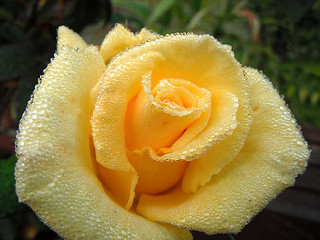

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

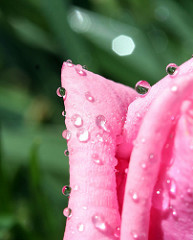

In [9]:
PIL.Image.open(str(roses[1]))

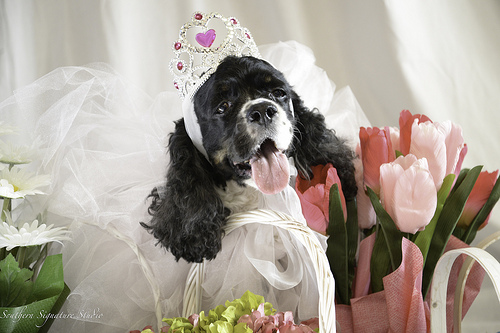

In [10]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

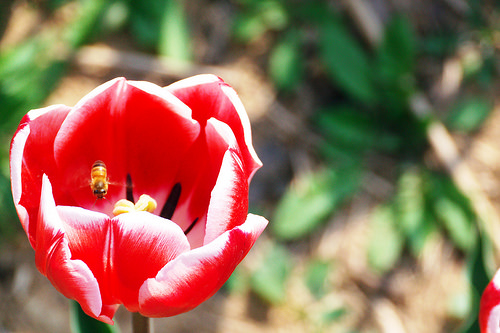

In [11]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

In [12]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [15]:
from tensorflow.python.ops.gen_batch_ops import batch
# It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,  img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

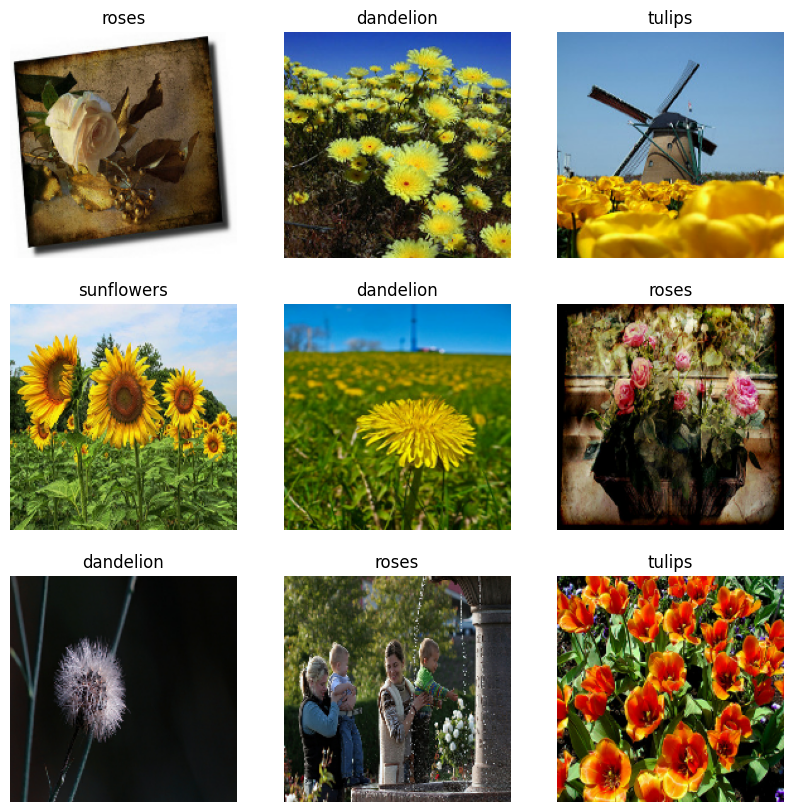

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

* **Dataset.cache** keeps the images in memory after they're loaded off disk during first epoch. This will ensure the dataset does not become a bottleneck while training the mode.
* **Dataset.prefetch**

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; In general I need to make the input value small.

Standarize values between [0, 1] range by using tf.keras.layers.Rescaling

In [22]:
normalization_layer = layers.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in '[0, 1]'
print(np.min(first_image), np.max(first_image))

0.0059910296 0.99424833


## A basic Keras model
### Create the model

In [26]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
86/92 [===========================>..] - ETA: 6s - loss: 1.3510 - accuracy: 0.4184

### Visualize the training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()